In [6]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from stone_bss import StoneBSS

In [7]:
VIDEO_PATH = "beam_animation.gif"
SCALE_FACTOR = 1

frames = []
cap = cv2.VideoCapture(VIDEO_PATH)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    og_h, og_w, _ = frame.shape
    w = int(og_w * SCALE_FACTOR)
    h = int(og_h * SCALE_FACTOR)

    frame = cv2.resize(frame, (w, h))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame / 255
    frames.append(frame)

video = np.array(frames)

num_frames = len(frames)
fps = cap.get(cv2.CAP_PROP_FPS)

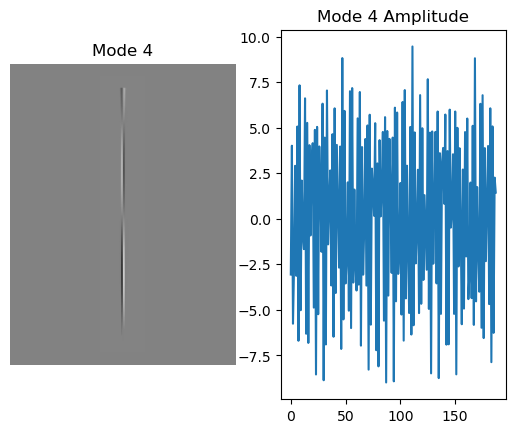

In [11]:
## Collapse frames down to 1 x N arrays
h, w = video[0].shape
collapsed_video = []
for frame in video:
    collapsed_video.append(frame.reshape(-1, 1))
collapsed_video = np.hstack(collapsed_video)

## Perform PCA on the video
X = torch.tensor(collapsed_video, device="cuda")
U, S, V = torch.svd(X)
U, S, V = np.array(U.cpu()), np.array(S.cpu()), np.array(V.cpu())

r = 6
U = U[:, :r]
S = S[:r]
V = V[:, :r]

## Project onto basis of generalized left eigenvectors
coordinates_on_U_basis = np.diag(S) @ V.T

## Separate modes
bss = StoneBSS()
W = bss.fit(coordinates_on_U_basis.T).T
modal_coordinates_on_U_basis = W @ coordinates_on_U_basis

# Extract desired mode
mode_number = 3
PHI_on_U_basis = np.linalg.inv(W)
mode_shape_on_U_basis = PHI_on_U_basis[:, mode_number].reshape(-1, 1)

# Extract time history of modal amplitude
amplitude_history_on_U_basis = modal_coordinates_on_U_basis[mode_number].reshape(1, -1)
mode_video_on_U_basis = mode_shape_on_U_basis @ amplitude_history_on_U_basis

## Project back onto original basis
mode_shape_on_original_basis = U @ mode_shape_on_U_basis
mode_video_on_original_basis = U @ mode_video_on_U_basis

## Rebuild frame back to h x w array
mode_shape_on_original_basis = np.reshape(mode_shape_on_original_basis, (h, w, 1))
mode_video_on_original_basis = np.reshape(mode_video_on_original_basis, (h, w, num_frames))

# Plot the mode shape as a picture
plt.subplot(121)
plt.title("Mode " + str(mode_number + 1))
plt.imshow(mode_shape_on_original_basis[:, :, 0], cmap="gray")
plt.axis("off")

# Plot the amplitude
plt.subplot(122)
plt.title("Mode " + str(mode_number + 1) + " Amplitude")
plt.plot(amplitude_history_on_U_basis.T)
plt.savefig("mode_" + str(mode_number) + ".png")

# Reconstruct a video with just the selected mode present
mode_video_on_original_basis = mode_video_on_original_basis.transpose(2, 0, 1)